In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import torch
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import plotly.express as px
import emoji
import contractions
import re
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import  Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [2]:
# read CSV file from the 'data' subdirectory using a relative path
data = pd.read_csv("./data/IMDB Dataset.csv")

# display the first 5 rows
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Inspect info about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
# Inspect data
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
# Check number of duplicates
print(f'Number of Duplicates')
print(len(data[data.duplicated()]))

Number of Duplicates
418


In [6]:
# Remove duplicates
data = data[~data.duplicated()]

<Axes: >

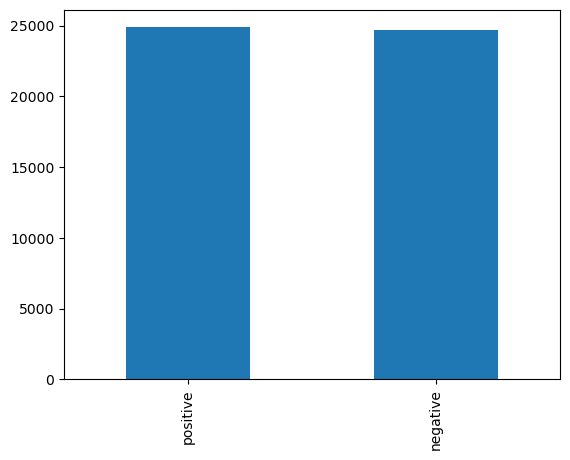

In [7]:
# Plot sentiment distribution
data.sentiment.value_counts().plot(kind='bar')

In [10]:
nlp = spacy.load('en_core_web_sm')
stopwords_list = stopwords.words('english')

# Define function to clear data 
def clean_lemmatize(text):
    # Decode emojis
    text = emoji.demojize(text)
    # Decode contractions
    text = contractions.fix(text)
    # Remove web links and html tags
    text = re.sub(r'https?://(www\.)?[\w-]+(\.[a-zA-Z]+)+|<.*?>|[^a-zA-Z\s]', ' ', text)
    # Remove whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Convert text to lower
    text = text.lower()
    # Convert text to tokens
    tokens = word_tokenize(text)
    # Remove stopwords and words longer than 1
    tokens = [word for word in tokens if word not in stopwords_list and len(word) > 1]
    words = nlp(" ".join(tokens))
    text = [word.lemma_ for word in words]
    return ' '.join(text)

In [11]:
# Clean text
data['review'] = data['review'].apply(clean_lemmatize)

In [12]:
# Define function to count every unique word
def count_words(data):
    words_counts = []
    for text in tqdm(data):
        words = word_tokenize(text)
        words_counts.extend(words)
    return Counter(words_counts).most_common()  

# Split data into positive and negative data
positive_words = data[data['sentiment'] == 'positive']
negative_words = data[data['sentiment'] == 'negative']


# Convert data into DataFrame
positive_words_count = pd.DataFrame(count_words(positive_words['review']), columns=['Words', 'Count'])
negative_words_count = pd.DataFrame(count_words(negative_words['review']), columns=['Words', 'Count'])

100%|██████████| 24698/24698 [00:03<00:00, 6236.87it/s]


In [13]:
# Plot top 10 most frequent words in positive sentiment 
px.bar(data_frame=positive_words_count[:10], x='Words', y='Count', title='Positive Word Frequency', color='Words')

In [14]:
# Plot top 10 most frequent words in negative sentiment
px.bar(data_frame=negative_words_count[:10], x='Words', y='Count', title='Negative Words Frequency', color='Words')

In [15]:
# Split data into data and target
X, y = data.drop('sentiment', axis=1), data['sentiment']

# Encode targets
encoder = LabelEncoder()

encoder.fit(y)

y_changed = encoder.transform(y)

In [16]:
# Define models
models = {
    'lg': LogisticRegression(),
    'lsvc': LinearSVC(),
}

# Define cross-validation
cv = StratifiedShuffleSplit(n_splits=5)

# Store confusion matrix and accuracy scores
confusion_matrix_scores = {}
accuracy_scores = {}

for model_name, model in models.items():  

    # Store each accuracy score from cross-validation split
    accuracy_list = []
    
    for idx, (train_index, test_index) in enumerate(cv.split(X, y_changed)):
    
        X_train, X_test = X.iloc[train_index].values.ravel(), X.iloc[test_index].values.ravel()
        y_train, y_test = y_changed[train_index], y_changed[test_index]
        
        print(f'{idx + 1} Split')
      
        pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', model)])
            
        pipe.fit(X_train, y_train)
            
        y_pred = pipe.predict(X_test)
            
        accuracy = accuracy_score(y_pred, y_test)
            
        cm = confusion_matrix(y_pred, y_test)
            
        print(f'Model {model_name}\nAccuracy score'
                  f': {accuracy}')
            
        if not model_name in confusion_matrix_scores.keys():
            confusion_matrix_scores[model_name] = cm
                
        accuracy_list.append(accuracy)
        
    accuracy_scores[model_name] = np.mean(accuracy_list)


1 Split
Model lg
Accuracy score: 0.8894938495664448
2 Split
Model lg
Accuracy score: 0.8872756604154063
3 Split


/Applications/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Model lg
Accuracy score: 0.8896955031256302
4 Split
Model lg
Accuracy score: 0.8898971566848155
5 Split
Model lg
Accuracy score: 0.8929219600725953
1 Split


/Applications/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



Model lsvc
Accuracy score: 0.896551724137931
2 Split


/Applications/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



Model lsvc
Accuracy score: 0.8955434563420044
3 Split


/Applications/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



Model lsvc
Accuracy score: 0.8967533776971164
4 Split


/Applications/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



Model lsvc
Accuracy score: 0.8941318814277072
5 Split


/Applications/anaconda3/envs/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



Model lsvc
Accuracy score: 0.8993748739665255


In [17]:
# Define function that plot confusion matrix for each model
def plot_confusion_matrix(cm_list, model_names_list):
    plt.figure(figsize=(20,5))
    for i in range(len(cm_list)):
        plt.subplot(1, 3, i+1)
        sns.heatmap(cm_list[i], annot=True, fmt='.0f')
        plt.title(model_names_list[i])
        plt.tight_layout()
    plt.show()
    
# Define function that plot accuracies for each model
def plot_accuracy(models, accuracy, title):
    plt.figure(figsize=(20, 5))
    plt.bar(x=models, height=accuracy)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title(title)

/var/folders/73/n7zl4nwn6y5d2phq5n48t5rr0000gn/T/ipykernel_74435/3763440224.py:8: UserWarning:

The figure layout has changed to tight



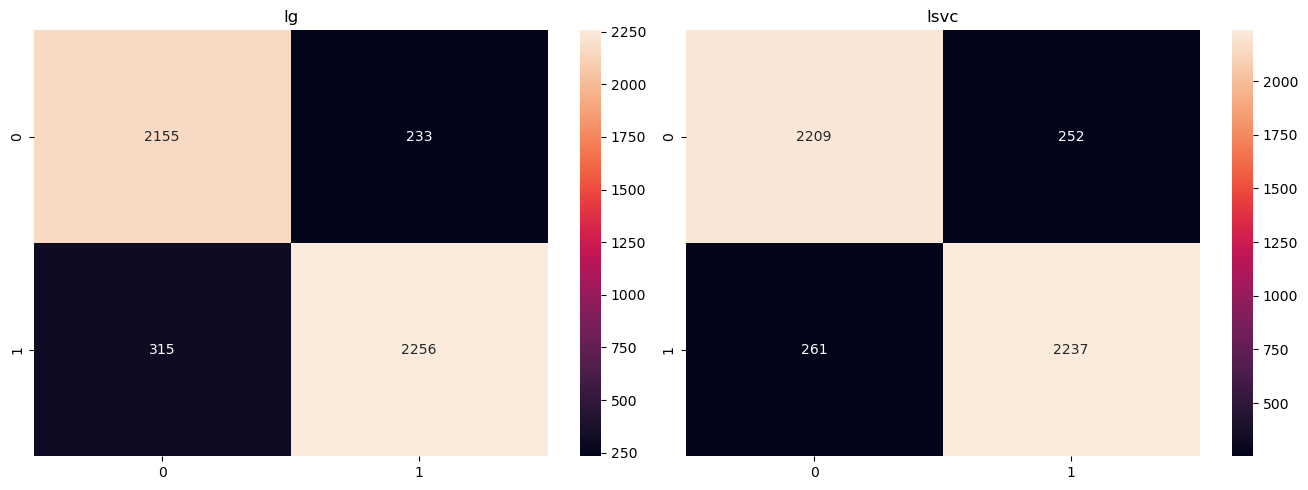

In [18]:
# Visualize confusion matrix
plot_confusion_matrix(list(confusion_matrix_scores.values()), list(confusion_matrix_scores.keys()))